#Flowchart for the MLP we are building

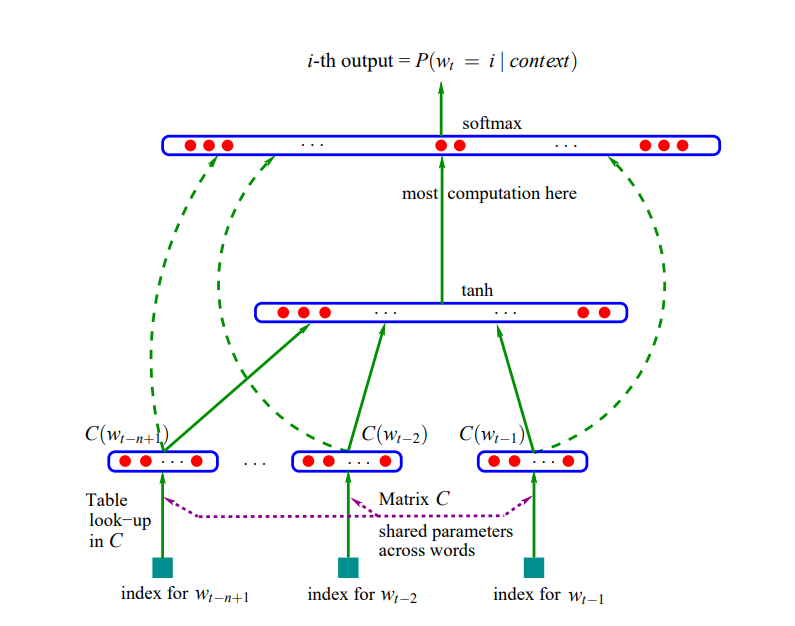

In [ ]:
from IPython.display import Image

# Path to the image file
image_path = '/content/MLP-character_model.png'

# Display the image
Image(filename=image_path)

# Lets Begin Coding

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#unpack our learning dataset
words = open('names.txt','r').read().splitlines()
words[:6]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte']

In [ ]:
len(words)

32033

In [ ]:
#Vocabulary of characters an mappings from/to integers

chars = sorted(list(set(''.join(words)))) # concatenate all dataset as a sinle string and passes it thru the set constructor

stoi = {s:i+1 for i,s in enumerate(chars)} # stoi maps a-0, b-1 and so on til z-25

# what about ourspecial char
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


#Build dataset

In [ ]:
block_size = 3 # context length: how many char do we take to predict the next one
X, Y = [], [] #X are input to the NN and Y are the label for each example inside X
for w in words[:5]: #rn first 5 for efficeincy
  print(w) 
  context = [0] * block_size # padded context of 0 tokens
  for ch in w + '.':
     ix = stoi[ch]     
     X.append(context) # stores the current running context context 
     Y.append(ix) # array y of the current character 
     print(''.join(itos[i] for i in context), '======>', itos[ix])
     context = context[1:] + [ix] # crop the context and append new char in sequence

X = torch.tensor(X)
Y = torch.tensor(Y)


emma
... ======> e
..e ======> m
.em ======> m
emm ======> a
mma ======> .
olivia
... ======> o
..o ======> l
.ol ======> i
oli ======> v
liv ======> i
ivi ======> a
via ======> .
ava
... ======> a
..a ======> v
.av ======> a
ava ======> .
isabella
... ======> i
..i ======> s
.is ======> a
isa ======> b
sab ======> e
abe ======> l
bel ======> l
ell ======> a
lla ======> .
sophia
... ======> s
..s ======> o
.so ======> p
sop ======> h
oph ======> i
phi ======> a
hia ======> .


In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype
#X
#Y

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [ ]:
# lets embed our 27 characters into a 2d space
C = torch.randn((27,2)) #each of the 27 char will have a 2d embedding


In [ ]:
# lets embed a single int for clarity before dealing with the whole X array
index_e = C[5]
#lets us onehot
onhot= F.one_hot(torch.tensor(5), num_classes=27).float() @ C
#remember that it needs to be a tensor not just int 5
#one hot has dtype int64 so we explicitly cast to float

print(index_e, onhot)

tensor([0.6933, 0.4658]) tensor([0.6933, 0.4658])


NOTE: this first piece here can be thought of as an integer indexing into a lookup table C.

> Equivalently it can be thought of as the first layer of the bigger NN. these are linear neurons and theirweight matrix is C, we are encoding integers into onehot and feeding into the NN and this first layer embeds them





for the purpose of this MLP code we are gonna discard the onehot method and just use indexing as it is much faster.



In [ ]:
#time to index integers and use embedding tables
# we can index with a list or a torch tensorhere I'm using tensors to keep everything consistent
#C[torch.tensor([5,6,6,7,8,8])] # 1d tensor
C[X].shape
 #multidim tensor (shape is 32, 3 and for each of these 32 by 3 integers we've retrieved the embedding vector)

torch.Size([32, 3, 2])

In [ ]:
X[13,2] #index 13, the second dim is the int 1

tensor(1)

In [ ]:
#lets index C of X by [13,2] of that array
eg1 = C[X][13,2]
# this gives the same result as because 1 is the interger at location X[13,2]
eg2 = C[1]

print(eg1,eg2)

tensor([0.1556, 0.2618]) tensor([0.1556, 0.2618])


In [ ]:
#lets actually embedd all integers simultaneously
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

# lets build the Hidden Layer

In [ ]:
#randm initialization of weights
#number of inputs to this layer is 3*2 = 6 (cause 2-d embedding of 3 )
W1 = torch.randn((6, 100)) # lets have 100 neurons
b1 = torch.randn(100)

In [ ]:
# now we want some way to emb @ W1 + b1 
# but cant matric multiply [32,3,2] with [6,100] GOTTA concatonat
emb[:, 0, :].shape #plucks out the 32 by 2 embedding of the first word in C

torch.Size([32, 2])

In [ ]:
#we want this for 3 dims and then concatenate the sequence stored in [] don't forget to put this around the emb
method1 = torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape
# but this is not general enough, if we change block size this wont work 
method1

torch.Size([32, 6])

In [ ]:
#dont worry we can use torch.unbind to get the same list 
#but now we can freely modify box size and ubind will take care of the rest
method2 = torch.cat(torch.unbind(emb,1), 1).shape
method2
# this is inefficient because the concatenate creates a whole new tensor and new memory is being created

torch.Size([32, 6])

In [ ]:
#CAn we make thsi more effecient??
#indeed we can by using .view to concatenate(must refer to how tensors work for further clarification)
#use emb.shape so that we don't hardcode 32, remember X will change once we consider more words
#alternate way is to simply use -1. pythorch will do the derivation for you

(emb.view(-1,6) @ W1 + b1).shape



torch.Size([32, 100])

NOTE: be careful here with the broadcasting of W1 and b1 due to the addition. we have 32,100 being broadcased on 0, 100. in this scenario it is what we want as the same bias vector will get added to all the rows of the (emb.view @ W1) matrix. 

In [ ]:
#lets add tanh to keep our numbers btwn -1 and 1 
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
h

tensor([[-0.9858,  0.9928, -0.8816,  ...,  0.5670,  0.9982,  0.9996],
        [-0.9996,  0.9999, -0.9978,  ..., -0.7828,  0.9999,  0.9940],
        [-0.9688,  0.9502, -0.9971,  ...,  0.7074,  0.9998,  0.9945],
        ...,
        [ 0.9944, -0.4155,  0.5450,  ..., -0.9982, -0.2966,  0.9797],
        [ 0.9998, -0.9847,  0.2343,  ...,  0.2828, -0.9966,  0.7719],
        [-0.8942,  0.9198, -0.4345,  ...,  0.9870,  0.9795, -0.1891]])

In [ ]:
h.shape

torch.Size([32, 100])

#Final layer (softmax) 

In [ ]:
W2 = torch.randn((100,27)) # input is now 100, output 27 cause 27 chars
b2 = torch.randn(27) # thus biases will be 27 as well (remember that broadcasting is right to left)

In [ ]:
# building our logits for log-likelihood
logits = h @ W2 + b2
logits.shape


torch.Size([32, 27])

In [ ]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims= True) # count sum along the first dim (makes our row probabilities sum to 1 prob.sum)
prob.shape

torch.Size([32, 27])

we now want to index into the rows of prob and each row we would like to pluck out the probability assigned to the correct character.

In [ ]:
#lets index into prob
#torch.arange(32 ) iterates the rows
#and we want to grab the column given by Y for each of those rows
prob[torch.arange(32),Y]

tensor([2.5658e-12, 3.5962e-08, 1.4821e-13, 3.6584e-11, 2.4113e-06, 1.3450e-08,
        6.5880e-10, 2.2741e-12, 2.6945e-07, 2.0758e-10, 2.5418e-14, 2.6405e-11,
        1.9869e-11, 2.9402e-09, 1.4758e-13, 6.6193e-08, 8.7550e-10, 4.6178e-13,
        1.4519e-09, 4.0476e-07, 9.3534e-17, 3.7332e-08, 9.8904e-01, 3.1133e-02,
        1.1896e-08, 1.4472e-14, 7.6175e-07, 2.3717e-08, 5.4788e-07, 8.7593e-07,
        8.6201e-02, 1.2512e-09])

In [ ]:
#lets now make the -ve log likelihood loss just as in bigram
loss = -prob[torch.arange(32),Y].log().mean()
loss

tensor(19.8360)

## Rewriting to make code look clean and nice

In [ ]:
X.shape, Y.shape #dataset

(torch.Size([32, 3]), torch.Size([32]))

**Generating parameters** (C, tanh layer and softmax)

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100), generator=g) # lets have 100 neurons
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g) # input is now 100, output 27 cause 27 chars
b2 = torch.randn(27, generator=g)

# make a single list of the parameters
param = [C,W1,b1,W2,b2]

In [ ]:
sum(p.nelement() for p in param) #number of total parameters

3481

**FORWARD PASS**
embedding in lookup table C, and building our -ve loss log-likelihood

In [ ]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2

#Note: the following three lines are simply just classification for the logits. 
# since a ton of ppl use classification pytorch has nn.functional.cross_entropy to deal with this stuff YAAY
## counts = logits.exp()
## prob = counts / counts.sum(1, keepdims= True)
## loss = -prob[torch.arange(32),Y].log().mean()


# lets now calculate the loss more efficiently
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

Note: using the counts method we we creating all new tensors in the memory. this will become very inefficient the bigger our data gets. Pytorch will instead cluster up all these operations and have fused kernels that will evaluate all this wayy more efficiently. 

this will also make the backward pass more efficient as the clusterd up expression wont have a convuluted back pass that is accounting for exp, sum, log and mean. instead similar to what happened in micrograd with tanh we will have a simpler backward pass as the expressions can take a much simpler form 

we use cross_entropy cause things will be more well behaved numerically. for example if the logits have spme superhigh positive value we might run into infinities. Pytorch however will find the highest logit and offset all logits such that the highest one gets subtracted and becomes a 0 leaving us with negative exponents. 

In [ ]:
for p in param:
  p.requires_grad = True

#remeber to set p.requires grad to true otherwise our backward pass is gonna give all sorts of errors

# Putting forward pass, backward pass and update all together

In [ ]:
for i in range(1000):
  #forward pass
  emb = C[X]
  h = torch.tanh(emb.view(-1,6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  

  #backward pass
  for p in param:
    p.grad = None
  loss.backward()

  #update
  for p in param:
    p.data += -0.1 * p.grad #0.1 learning rate for now

print(loss.item())

0.25565722584724426


the reason we are getting such a nice loss is beacuse we are overfitting our parameters. remember 3481 parameters on 32 examples.

Lets now do this for the full data set in a new and clean notebook.